# Treeconomy Geosptial Scientist Investigation Project
Assess locations for potential rewilding in South East of the DR Congo:

Develop a Geospatial Framework to assess suitability based on past and exisitng tree coverage, land cover type, regions of special interest / conservation and terrain. 

### Harmonize all data layers in location and resolution based on a single layer.
For this, I am using the ESA World cover Land cover classification, which is based on Sentinel-2 data, with a resolution of 10m 

### Clip World cover data by a bounding box defined by the aoi geojson data provided. 

In [1]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import box

gdf = gpd.read_file("roi.geojson")
input_raster = "ESA_WorldCover_10m_2021_v200_S12E027_Map.tif"
output_raster = "framework/World_cover_reference_layer.tif"

# aoi_coords_wgs84 = [4.20762, 50.764694, 4.487708, 50.916455]
aoi_coords_wgs84 = gdf.total_bounds.tolist()

# Create bounding box geometry
bbox_geom = box(*aoi_coords_wgs84)

# Convert bounding box to a GeoDataFrame
bbox_gdf = gpd.GeoDataFrame(
    {"geometry": [bbox_geom]}, 
    crs="EPSG:4326"  # Adjust the CRS as needed
)

# Open the raster file
with rasterio.open(input_raster) as src:
    # Reproject the bounding box to the raster's CRS
    # Clip the raster using the bounding box
    out_image, out_transform = mask(src, bbox_gdf.geometry, crop=True)
    out_meta = src.meta.copy()

# Update metadata
out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

# Save the clipped raster
with rasterio.open(output_raster, "w", **out_meta) as dest:
    dest.write(out_image)


## Create Framework layers

### Clip S2 data and produce NDVI 

In [17]:
def clip_band(band_path, aoi_geom):
    with rasterio.open(band_path) as src:
        clipped_band, clipped_transform = mask(
            src, aoi_geom.geometry, crop=True)
        meta = src.meta.copy()
        meta.update({
            "height": clipped_band.shape[1],
            "width": clipped_band.shape[2],
            "transform": clipped_transform
        })
    return clipped_band[0].astype('float32'), meta

with rasterio.open("S2_Data/T35LPH_20180523T080711_B04_10m.jp2") as src:
    # Reproject AOI to the image CRS
    aoi_projected = bbox_gdf.to_crs(src.crs)

# Clip the bands
red_band_clipped, red_meta = clip_band("S2_Data/T35LPH_20210507T080611_B04_10m.jp2", aoi_projected)
nir_band_clipped, _ = clip_band("S2_Data/T35LPH_20210507T080611_B08_10m.jp2", aoi_projected)


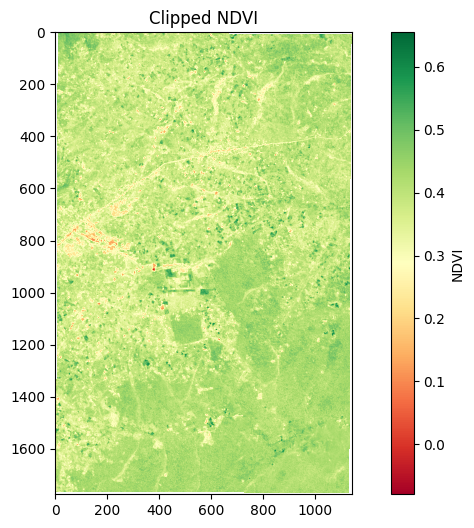

In [18]:
import numpy as np
# Avoid division by zero
np.seterr(divide='ignore', invalid='ignore')

# Calculate NDVI
ndvi_clipped = (nir_band_clipped - red_band_clipped) / (nir_band_clipped + red_band_clipped)

# Plot NDVI
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.title("Clipped NDVI")
plt.imshow(ndvi_clipped, cmap='RdYlGn')
plt.colorbar(label='NDVI')
plt.show()


### Export raw NDVI data

In [25]:
output_ndvi_path = "to_harmonize/2021_ndvi.tif"

# Update metadata and save
red_meta.update(driver='GTiff', dtype='float32')

with rasterio.open(output_ndvi_path, 'w', **red_meta) as dst:
    dst.write(ndvi_clipped, 1)

## Harmonize raster layers in resolution and projection

In [119]:
import os
from rasterio.warp import reproject, Resampling

# Define the harmonization function
def harmonize_raster(reference_raster, input_raster, output_raster):
    with rasterio.open(reference_raster) as ref_src:
        ref_crs = ref_src.crs
        ref_transform = ref_src.transform
        ref_width = ref_src.width
        ref_height = ref_src.height

        with rasterio.open(input_raster) as src:
            profile = src.profile.copy()

            # Update profile to match the reference raster
            profile.update({
                "crs": ref_crs,
                "transform": ref_transform,
                "width": ref_width,
                "height": ref_height
            })

            # Write the harmonized output
            with rasterio.open(output_raster, "w", **profile) as dst:
                for i in range(1, src.count + 1):  # Process each band
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=ref_transform,
                        dst_crs=ref_crs,
                        resampling=Resampling.nearest
                    )

# Apply the function to all files in a folder
def batch_harmonize(reference_raster, input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('.tif', '.tiff')):
            input_raster = os.path.join(input_folder, filename)
            output_raster = os.path.join(output_folder, filename)
            harmonize_raster(reference_raster, input_raster, output_raster)
            print(f"Processed: {filename}")

# Example Usage
reference_raster = "framework/World_cover_reference_layer.tif"
input_folder = "to_harmonize"
output_folder = "harmonized"

batch_harmonize(reference_raster, input_folder, output_folder)


Processed: 2018_ndvi.tif
Processed: 2024_ndvi.tif
Processed: DEM_slope.tif
Processed: 2021_ndvi.tif


### Threshold NDVI Layers

In [121]:
def apply_binary_threshold(input_folder, output_folder, threshold_value=100):
    """
    Apply a binary threshold to all raster files in a folder.

    Parameters:
    - input_folder (str): Path to the folder containing input rasters.
    - output_folder (str): Path to the folder where output rasters will be saved.
    - threshold_value (float): Threshold value for binary classification.
    """

    # Ensure output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Loop through all raster files in the input folder
    for file_name in os.listdir(input_folder):
        if 'ndvi' in file_name.lower() and file_name.lower().endswith(('.tif', '.tiff')):
            input_raster = os.path.join(input_folder, file_name)
            output_raster = os.path.join(output_folder, f"binary_{file_name}")

            # Process the raster
            with rasterio.open(input_raster) as src:
                raster_data = src.read(1)
                transform = src.transform
                crs = src.crs
                width = src.width
                height = src.height
                nodata_value = src.nodata

            # Apply the binary threshold
            binary_output = np.where(raster_data > threshold_value, 1, 0)

            # Save the binary raster
            with rasterio.open(
                output_raster, "w",
                driver="GTiff", height=height, width=width, count=1,
                dtype="uint8", crs=crs, transform=transform
            ) as dst:
                dst.write(binary_output.astype(np.uint8), 1)

            print(f"Processed and saved: {output_raster}")

# Example usage:
input_folder = "harmonized"
output_folder = "framework"
apply_binary_threshold(input_folder, output_folder, threshold_value=0.4)



Processed and saved: framework/binary_2018_ndvi.tif
Processed and saved: framework/binary_2024_ndvi.tif
Processed and saved: framework/binary_2021_ndvi.tif


### Add a distance wighted buffer around existing woodland

In [ ]:
from scipy.spatial import cKDTree
from rasterio.transform import from_origin

# Paths
land_class_raster = "framework/binary_2024_ndvi.tif"
output_raster = "framework/tree_buffer_scored.tif"

# Open the land classification raster
with rasterio.open(land_class_raster) as src:
    land_class_data = src.read(1)  # Read the first band (land class values)
    transform = src.transform
    crs = src.crs
    width = src.width
    height = src.height
    bounds = src.bounds

# Identify the tree class pixels (class 1)
tree_pixels = np.where(land_class_data == 1)  # Get coordinates of tree class (class 1) pixels

# Generate grid points (pixel centers) for distance calculation
x_coords = np.linspace(bounds[0] + transform[0] / 2, bounds[2] - transform[0] / 2, width)
y_coords = np.linspace(bounds[3] - transform[4] / 2, bounds[1] + transform[4] / 2, height)

grid_x, grid_y = np.meshgrid(x_coords, y_coords)

# Flatten grid points for distance calculation
grid_points = np.vstack((grid_x.ravel(), grid_y.ravel())).T

# Convert tree pixel indices to coordinates in the same system as the grid
tree_points = np.vstack([grid_x[tree_pixels], grid_y[tree_pixels]]).T

# Calculate distances from each grid point to the nearest tree pixel using cKDTree
tree_kdtree = cKDTree(tree_points)
distances, _ = tree_kdtree.query(grid_points)

# Create a new raster where pixels within 1 km are set to 1
buffer_radius = 0.001  # 1km 

distances_arr = distances.reshape(height, width)

# Assign 1 to pixels within 500m of a tree, and 0 to others
# buffered_raster = np.where(distances_arr <= buffer_radius, 1, 0)
scored_raster = np.clip(1 - (distances_arr / buffer_radius), 0, 1)


# Step 7: Save the buffered raster as a new GeoTIFF
with rasterio.open(
    output_raster, "w",
    driver="GTiff", height=height, width=width, count=1,
    dtype="float32", crs=crs, transform=transform
) as dst:
    dst.write(scored_raster, 1)
    # dst.write(buffered_raster, 1)

print(f"Buffered raster saved to {output_raster}")


Buffered raster saved to framework/tree_buffer_scored.tif


### Rasterize national park data

In [ ]:
from rasterio.features import rasterize

# Paths
shapefile = gpd.read_file("wdpamay2017cod-shapefile-polygons/WDPA_May2017_COD-shapefile-polygons.shp")
reference_raster = "harmonized_raster2.tif"
output_raster = "framework/rasterized_clip_protected_areas.tif"
aoi = bbox_gdf.copy()

# Ensure CRS matches
if shapefile.crs != aoi.crs:
    shapefile = shapefile.to_crs(aoi.crs)

# Clip the shapefile
clipped = gpd.overlay(shapefile, aoi, how='intersection')

# Use an existing raster as a reference
with rasterio.open(reference_raster) as ref_raster:
    ref_meta = ref_raster.meta.copy()

# Define rasterization settings
transform = ref_meta['transform']
out_shape = (ref_meta['height'], ref_meta['width'])

# Convert to GeoJSON-like format for rasterization
shapes = [(geom, 1) for geom in clipped.geometry]

# Rasterize and save
rasterized = rasterize(
    shapes,
    out_shape=out_shape,
    transform=transform,
    fill=0,  # Outside the polygon
    dtype='uint8'
)

# Update metadata
ref_meta.update({"driver": "GTiff", "dtype": "uint8", "count": 1})

# Save the result
with rasterio.open(output_raster, "w", **ref_meta) as dest:
    dest.write(rasterized, 1)


### Classification areas

In [115]:
# Path to the classification raster
classification_raster = "framework/World_cover_reference_layer.tif"
output_raster = "framework/classification_scores.tif"

# Dictionary mapping class values to scores
class_to_score = {
    10: 1.0,
    20: 0.6,
    30: 0.3,
    40: 0.3
}

# Read the classification raster
with rasterio.open(classification_raster) as src:
    classification_data = src.read(1)  # Read the first band (class values)
    transform = src.transform
    crs = src.crs
    width = src.width
    height = src.height
    nodata_value = src.nodata

# Map the class values to scores, assigning 0 for classes not in the dictionary
# Create an array to hold the scores
score_array = np.zeros_like(classification_data, dtype='float32')  # Start with all zeros

# Apply the mapping: If the class exists in the dictionary, assign the corresponding score
for class_value, score in class_to_score.items():
    score_array[classification_data == class_value] = score

# Update the metadata for the output raster
out_meta = src.meta.copy()
out_meta.update({
    "dtype": "float32",  # Ensure the dtype is suitable for floating point scores
    "count": 1,  # Single band output
    "nodata": np.nan,  # Handle no-data values
})

# Save the output raster with the mapped scores
with rasterio.open(output_raster, "w", **out_meta) as dest:
    dest.write(score_array, 1)

print(f"Output raster saved to {output_raster}")


Output raster saved to framework/classification_scores.tif


### Slope

In [204]:
# Path to the slope raster
slope_raster = "harmonized/DEM_slope.tif"
output_raster = "framework/scored_DEM_slope.tif"

# Read the slope raster
with rasterio.open(slope_raster) as src:
    slope_data = src.read(1)  # Read the first band (slope values)


# Apply the classification based on the thresholds
# Use np.select() to apply multiple conditions
conditions = [
    (slope_data <= 15),   # Slope <= 15
    (slope_data > 15) & (slope_data <= 30),  # 15 < Slope <= 30
    (slope_data > 30)     # Slope > 30
]

# Corresponding scores for each condition
scores = [1, 0.5, 0]

# Assign scores based on the conditions
score_array = np.select(conditions, scores, default=0)  # Default 0 for undefined areas

# Update the metadata for the output raster
out_meta = src.meta.copy()
out_meta.update({
    "dtype": "float32",  # Ensure the dtype is suitable for floating point scores
    "count": 1,  # Single band output
    "nodata": np.nan,  # Handle no-data values
})

# Save the output raster with the scores
with rasterio.open(output_raster, "w", **out_meta) as dest:
    dest.write(score_array, 1)

print(f"Output raster saved to {output_raster}")


Output raster saved to framework/scored_DEM_slope.tif


## Create Mask

In [86]:
def rasterize_shapefile_to_match_raster(
    shapefile_path, reference_raster_path, output_raster_path, bbox_gdf
):
    """
    Rasterizes a shapefile based on a reference raster's properties.

    Parameters:
    - shapefile_path (str): Path to the input shapefile.
    - reference_raster_path (str): Path to the reference raster file.
    - output_raster_path (str): Path to save the rasterized output.
    - bbox_gdf (GeoDataFrame): A bounding box GeoDataFrame to clip the shapefile.

    Returns:
    - None: Saves the rasterized file at the specified output path.
    """
    # Load shapefile and bounding box GeoDataFrame
    shapefile = gpd.read_file(shapefile_path)
    aoi = bbox_gdf

    # Ensure CRS matches
    if shapefile.crs != aoi.crs:
        shapefile = shapefile.to_crs(aoi.crs)

    # Clip the shapefile
    clipped = gpd.overlay(shapefile, aoi, how="intersection")

    # Use the reference raster's metadata
    with rasterio.open(reference_raster_path) as ref_raster:
        ref_meta = ref_raster.meta.copy()
        transform = ref_meta['transform']
        out_shape = (ref_meta['height'], ref_meta['width'])

    # Convert clipped geometries to a format compatible with rasterization
    shapes = [(geom, 1) for geom in clipped.geometry]

    # Rasterize and save
    rasterized = rasterize(
        shapes,
        out_shape=out_shape,
        transform=transform,
        fill=0,  # Outside the polygon
        dtype='uint8'
    )

    # Update metadata
    ref_meta.update({"driver": "GTiff", "dtype": "uint8", "count": 1})

    # Save the result
    with rasterio.open(output_raster_path, "w", **ref_meta) as dest:
        dest.write(rasterized, 1)

    print(f"Rasterized file saved at {output_raster_path}")


### Create Framework mask

### Start with ROI mask

In [100]:
bbox_gdf = gpd.read_file("roi.geojson")
rasterize_shapefile_to_match_raster(
    shapefile_path="roi.geojson",
    reference_raster_path="harmonized_raster2.tif",
    output_raster_path="mask/roi_mask_v2.tif",
    bbox_gdf=bbox_gdf
)

Rasterized file saved at mask/roi_mask_v2.tif


### Then, create existing woodland mask 

In [101]:
input_raster = "ndvi_harmonized/2024_ndvi.tif"
threshold_value = 0.4
output_raster = "mask/existing_forest_mask_v1.tif"
# Process the raster
with rasterio.open(input_raster) as src:
    raster_data = src.read(1)
    transform = src.transform
    crs = src.crs
    width = src.width
    height = src.height
    nodata_value = src.nodata

# Apply the binary threshold
binary_output = np.where(raster_data < threshold_value, 1, 0)

# Save the binary raster
with rasterio.open(
    output_raster, "w",
    driver="GTiff", height=height, width=width, count=1,
    dtype="uint8", crs=crs, transform=transform, nodata=0
) as dst:
    dst.write(binary_output.astype(np.uint8), 1)

### Finally, create land cover mask

In [102]:
input_raster = "framework/clipped_raster.tif"
excluded_values = [50, 80]
output_raster = "mask/land_cover_mask_v1.tif"
# Process the raster
with rasterio.open(input_raster) as src:
    raster_data = src.read(1)
    transform = src.transform
    crs = src.crs
    width = src.width
    height = src.height
    nodata_value = src.nodata

# Apply the binary threshold
binary_output = np.where(~np.isin(raster_data, excluded_values), 1, 0)

# Save the binary raster
with rasterio.open(
    output_raster, "w",
    driver="GTiff", height=height, width=width, count=1,
    dtype="uint8", crs=crs, transform=transform
) as dst:
    dst.write(binary_output.astype(np.uint8), 1)

### Put it all together as an aggregated mask layer

In [ ]:
# Paths to harmonized raster files
roi_path = "mask/roi_mask_v2.tif"
existing_forest_path = "mask/existing_forest_mask_v1.tif"
land_cover_path = "mask/land_cover_mask_v1.tif"
output_path = "framework/framework_mask.tif"

# Read rasters into arrays
with rasterio.open(roi_path) as src1, rasterio.open(existing_forest_path) as src2, rasterio.open(land_cover_path) as src3:
    raster1 = src1.read(1, masked=True)  # Mask nodata values
    raster2 = src2.read(1, masked=True)
    raster3 = src3.read(1, masked=True)

    # Multiply the arrays element-wise
    multiplied_array = raster1 * raster2 * raster3

    # Update metadata for the output file
    out_meta = src1.meta.copy()
    out_meta.update({
        "dtype": "uint8",  # Output will be binary (0 or 1)
        "count": 1,  # Single band output
        "nodata": 0,  # Handle no-data values
    })

# Save the multiplied array as a new raster
with rasterio.open(output_path, "w", **out_meta) as dest:
    dest.write(multiplied_array.astype("uint8"), 1)

print(f"Multiplied raster saved to {output_path}")


Multiplied raster saved to framework/framework_mask.tif


## Additional layers (not used)

### Clip and rasterize road netwrok layer

In [51]:
# Paths
vector_file = "hotosm_cod_roads_lines_shp/hotosm_cod_roads_lines_shp.shp"
template_raster = "aggregated_raster.tif"  # Path to your template raster
output_raster = "road_distance_raster.tif"

roi = gpd.read_file("roi.geojson")

# Get the bounding box coordinates
bbox_coords = [28.051454522577046, -11.106410082760304, 28.155177466443035, -10.94628797263448]
xmin, ymin, xmax, ymax = bbox_coords

# Open the template raster to extract its properties
with rasterio.open(template_raster) as src:
    template_transform = src.transform
    template_crs = src.crs
    template_width = src.width
    template_height = src.height
    template_bounds = src.bounds

# Verify bounding box dimensions
width = xmax - xmin
height = ymax - ymin
print(f"Bounding Box Dimensions - Width: {width}, Height: {height}")

# Define the raster transform from the template (this ensures alignment)
transform = template_transform

# Load and clip the vector dataset
gdf = gpd.read_file(vector_file)
# bbox_geom = box(*bbox_coords)
clipped_gdf = gpd.clip(gdf, gpd.GeoDataFrame({"geometry": [bbox_geom]}, crs=gdf.crs))

# Generate grid points (centers of each pixel) using template dimensions
x_coords = np.linspace(template_bounds[0] + (template_bounds[2] - template_bounds[0]) / template_width / 2, 
                       template_bounds[2] - (template_bounds[2] - template_bounds[0]) / template_width / 2, 
                       template_width)
y_coords = np.linspace(template_bounds[3] - (template_bounds[3] - template_bounds[1]) / template_height / 2, 
                       template_bounds[1] + (template_bounds[3] - template_bounds[1]) / template_height / 2, 
                       template_height)
grid_x, grid_y = np.meshgrid(x_coords, y_coords)

# Flatten grid points for distance calculation
grid_points = np.vstack((grid_x.ravel(), grid_y.ravel())).T

# Extract coordinates from vector geometry
line_points = np.vstack([
    np.array(geom.coords) for geom in clipped_gdf.geometry if geom.geom_type in ["LineString", "MultiLineString"]
])

# Use a KDTree for efficient distance calculation
tree = cKDTree(line_points)
distances, _ = tree.query(grid_points)

# Reshape distances back to raster shape and normalize
distance_array = distances.reshape(template_height, template_width)
distance_array = np.clip(1 - (distance_array / 0.00500), 0, 1)  # Normalize to 0-1

# Save the distance raster using the template's CRS and transform
with rasterio.open(
    output_raster, "w",
    driver="GTiff", height=template_height, width=template_width, count=1,
    dtype="float32", crs=template_crs, transform=transform, nodata=np.nan
) as dst:
    dst.write(distance_array, 1)

print(f"Distance raster saved to {output_raster}")



Bounding Box Dimensions - Width: 0.10372294386598924, Height: 0.16012211012582434
Distance raster saved to road_distance_raster.tif


## Generate Geospatial model 

Aggregated raster saved to framework/result.tif


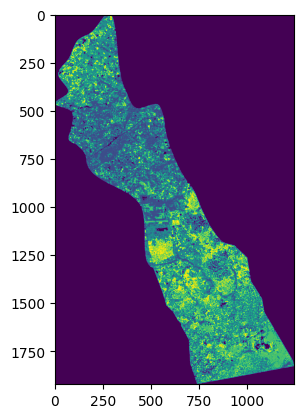

In [296]:
# Define paths to the input raster layers and their corresponding weights
raster_weights = {
    "framework/classification_scores.tif": 0,
    "framework/binary_2021_ndvi.tif": 1,
    "framework/binary_2018_ndvi.tif": 0.6,
    "framework/rasterized_clip_protected_areas.tif": 0,
    "framework/scored_DEM_slope.tif": 0.5,
    "framework/tree_buffer_scored.tif": 0,

}

model_max = np.sum(list(raster_weights.values()))

mask_layer_path = "framework/framework_mask.tif"
with rasterio.open(mask_layer_path) as mask_src:
    mask_data = mask_src.read(1)  # Read the mask layer (assuming single-band raster)

# Initialize a variable to hold the weighted sum
weighted_sum = None

# Loop over each raster and its corresponding weight
for raster_path, weight in raster_weights.items():
    with rasterio.open(raster_path) as src:
        raster_data = src.read(1)  # Read the first band (assuming single-band rasters)
        
        # Apply weight to the raster layer
        weighted_layer = raster_data * weight
        
        # Sum the weighted layers
        if weighted_sum is None:
            weighted_sum = weighted_layer
        else:
            weighted_sum += weighted_layer

        normalised_sum = weighted_sum/model_max

        masked_result = normalised_sum * mask_data

# Define the metadata for the output raster
with rasterio.open(list(raster_weights.keys())[0]) as src:
    out_meta = src.meta.copy()
    out_meta.update({
        "dtype": "float32",  # Change data type if needed
        "count": 1,  # Single band output
        "nodata": np.nan  # Handle no-data values
    })

# Save the aggregated raster as a new file
output_raster = "framework/result.tif"
with rasterio.open(output_raster, "w", **out_meta) as dest:
    dest.write(masked_result.astype("float32"), 1)

print(f"Aggregated raster saved to {output_raster}")
plt.imshow(masked_result)


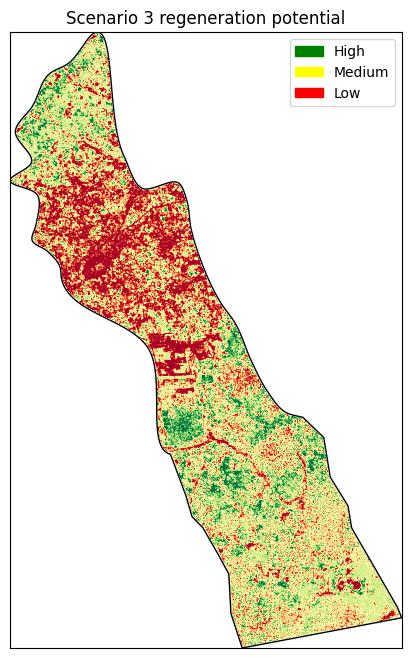

In [299]:
from rasterio.mask import mask
from matplotlib.patches import Patch

# Paths to files
tif_file = "framework/result.tif"   # Replace with your GeoTIFF path
shapefile = "roi.geojson"  # Replace with your shapefile path
mask_layer_path = "mask/roi_mask_v2.tif"

# Load the GeoTIFF
with rasterio.open(tif_file) as src:
    raster = src.read(1)  # Read the first band
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    crs = src.crs  # CRS of the GeoTIFF

# Load the shapefile with Geopandas
gdf = gpd.read_file(shapefile)

# Ensure the shapefile CRS matches the raster CRS
if gdf.crs != crs:
    gdf = gdf.to_crs(crs)

# Mask the raster with the shapefile polygon
with rasterio.open(tif_file) as src:
    # Mask the raster with the shapefile
    out_image, out_transform = mask(src, gdf.geometry, crop=True)
    out_image = out_image[0]  # Extract the first band

# Mask no-data values (optional)
out_image = np.ma.masked_equal(out_image, src.nodata)

# Classify the raster values based on the breakpoints
conditions = [
    (out_image <= 0.5),   # Class 1: Low NDVI change
    (out_image > 0.5) & (out_image <= 0.9),  # Class 2: Moderate NDVI change
    (out_image > 0.9)     # Class 3: High NDVI change
]

# Corresponding class scores for each condition
classes = [0.01, 0.6, 1]  # Class values, can be adjusted

# Assign classes based on the conditions
classified_raster = np.select(conditions, classes, default=np.nan)  # Use NaN for outside the polygon

# Mask out areas that are NaN (outside the polygon) after classification
classified_raster = np.ma.masked_invalid(classified_raster)

# Plot the results
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the classified raster
cax = ax.imshow(classified_raster, cmap="RdYlGn", extent=extent, vmin=0, vmax=1)

# Add the shapefile overlay (boundary of the region of interest)
gdf.plot(ax=ax, facecolor="none", edgecolor="k", linewidth=1)

ax.set_title("Scenario 3 regeneration potential")

# Optionally remove axes ticks and labels for a cleaner plot
ax.set_xticks([])
ax.set_yticks([])

# Create custom legend
legend_elements = [
    Patch(color="green", label="High"),
    Patch(color="yellow", label="Medium"),
    Patch(color="red", label="Low")
    
]

# Add the legend to the plot
ax.legend(handles=legend_elements, loc="upper right")

# Show the plot
plt.show()


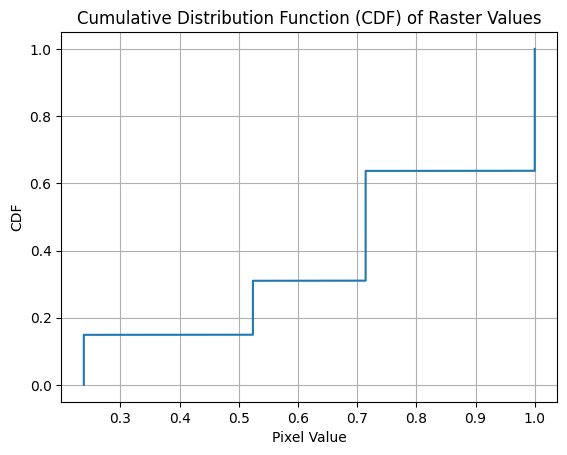

In [298]:
# Flatten the array
flat_raster = masked_result.flatten()

# Exclude zeros
non_zero_values = flat_raster[flat_raster > 0]

# Sort the values
sorted_values = np.sort(non_zero_values)

# Compute the CDF (cumulative sum)
cdf = np.cumsum(sorted_values)

# Normalize the CDF to range from 0 to 1
cdf_normalized = cdf / cdf[-1]  # Normalize by dividing by the last value in the cumulative sum

# Plot the CDF
plt.plot(sorted_values, cdf_normalized)
plt.xlabel('Pixel Value')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function (CDF) of Raster Values')
plt.grid(True)
plt.show()


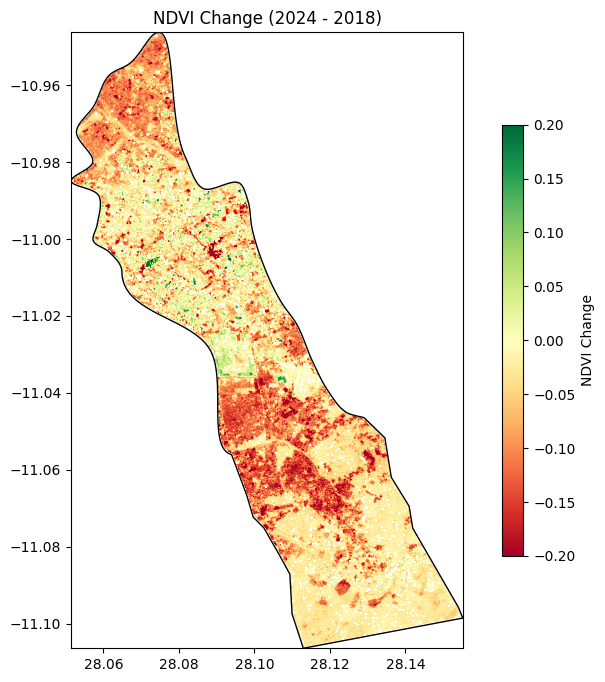

In [241]:
# Paths to files
tif_file1 = "framework/2024_ndvi.tif"   # Replace with your GeoTIFF path
tif_file2 = "framework/2018_ndvi.tif"   # Replace with your GeoTIFF path

shapefile = "roi.geojson"  # Replace with your shapefile path
mask_layer_path = "mask/roi_mask_v2.tif"

# Load the GeoTIFF
with rasterio.open(tif_file1) as src1, rasterio.open(tif_file2) as src2:
    latest = src1.read(1)  # Read the first band
    baseline = src2.read(1)
    extent = [src1.bounds.left, src1.bounds.right, src1.bounds.bottom, src1.bounds.top]
    crs = src1.crs  # CRS of the GeoTIFF
    raster = latest - baseline
    
with rasterio.open(mask_layer_path) as mask_src:
    mask_data = mask_src.read(1) 

# data_masked = data * mask_data
# Mask no-data values (optional)
raster = np.ma.masked_equal(raster, src.nodata)
raster = raster * mask_data
raster = np.ma.masked_equal(raster, 0)
# Load the shapefile with Geopandas
gdf = gpd.read_file(shapefile)

# Reproject the shapefile to match the raster CRS (if necessary)
if gdf.crs != crs:
    gdf = gdf.to_crs(crs)

# Plot the data
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the GeoTIFF
cax = ax.imshow(raster, cmap="RdYlGn", extent=extent, vmin =-0.2, vmax = 0.2)

# Add the shapefile overlay
gdf.plot(ax=ax, facecolor="none", edgecolor="k", linewidth=1)

# Add colorbar and labels
cbar = fig.colorbar(cax, ax=ax, orientation="vertical", shrink=0.7)
cbar.set_label("NDVI Change")

ax.set_title("NDVI Change (2024 - 2018)")
# ax.set_xlabel("Longitude")
# ax.set_ylabel("Latitude")

# Show the plot
plt.show()

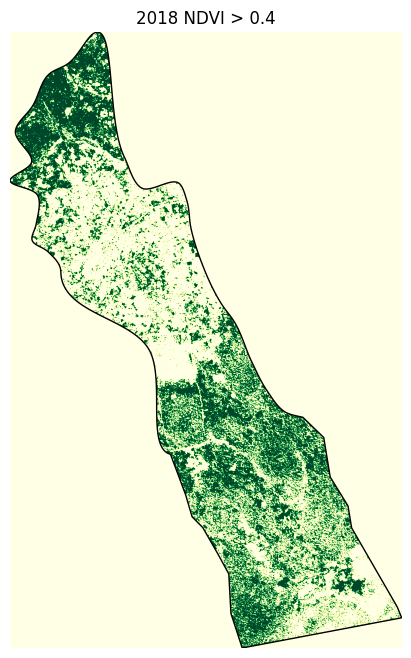

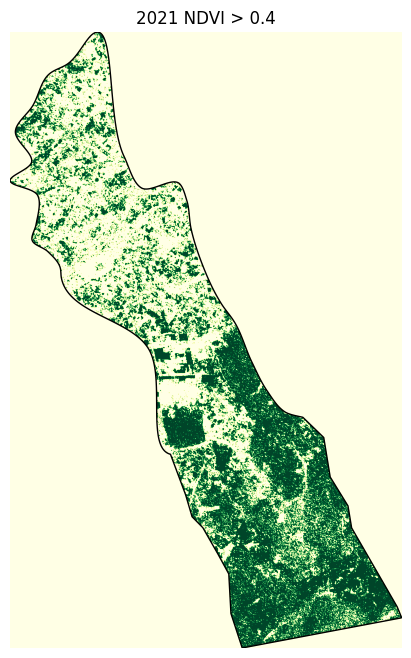

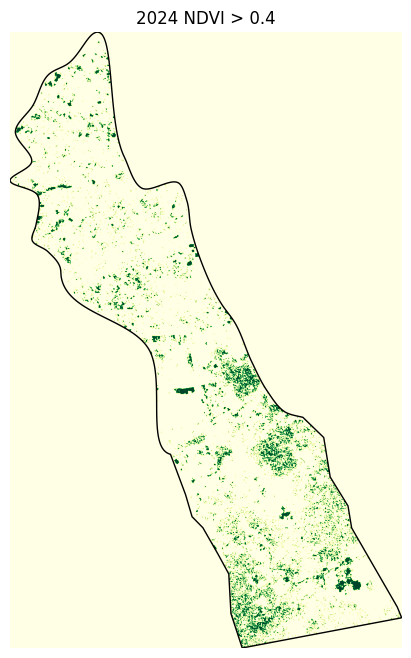

In [252]:
images = ["2018", "2021", "2024"]

for image in images:
    # Paths to files
    tif_file = f"framework/binary_{image}_ndvi.tif"   # Replace with your GeoTIFF path

    shapefile = "roi.geojson"  # Replace with your shapefile path
    mask_layer_path = "mask/roi_mask_v2.tif"

    # Load the GeoTIFF
    with rasterio.open(tif_file) as src:
        raster = src.read(1)  # Read the first band
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
        crs = src.crs  # CRS of the GeoTIFF
        
    with rasterio.open(mask_layer_path) as mask_src:
        mask_data = mask_src.read(1) 

    # data_masked = data * mask_data
    # Mask no-data values (optional)
    raster = np.ma.masked_equal(raster, src.nodata)
    raster = raster * mask_data
    # raster = np.ma.masked_equal(raster, 0)
    # Load the shapefile with Geopandas
    gdf = gpd.read_file(shapefile)

    # Reproject the shapefile to match the raster CRS (if necessary)
    if gdf.crs != crs:
        gdf = gdf.to_crs(crs)

    # Plot the data
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot the GeoTIFF
    cax = ax.imshow(raster, cmap="YlGn", extent=extent, vmax=1)

    # Add the shapefile overlay
    gdf.plot(ax=ax, facecolor="none", edgecolor="k", linewidth=1)

    # Add colorbar and labels
    # cbar = fig.colorbar(cax, ax=ax, orientation="vertical", shrink=0.7)
    # cbar.set_label("NDVI")

    ax.set_title(f"{image} NDVI > 0.4")
    ax.set_axis_off()
    # ax.set_xlabel("Longitude")
    # ax.set_ylabel("Latitude")

    # Show the plot
    plt.show()



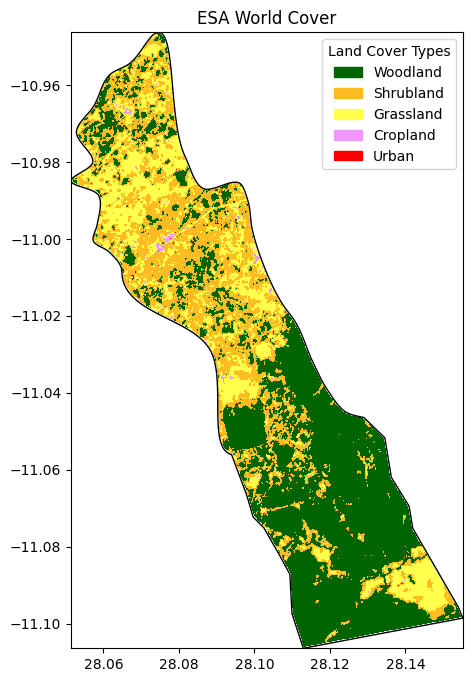

In [261]:
# Paths to files
tif_file = "framework/World_cover_reference_layer.tif"   # Replace with your GeoTIFF path
shapefile = "roi.geojson"  # Replace with your shapefile path

# Define your classes and corresponding colors
classes = [10, 20, 30, 40, 50]  # Example class values
colors = ["#006400", "#ffbb22", "#ffff4c", "#f096ff", "#fa0000"]  # Custom colors
cmap = ListedColormap(colors)
norm = BoundaryNorm(classes + [classes[-1] + 1], len(classes))  # Define boundaries for class normalization

# Class names for the legend
class_names = {
    10: "Woodland",
    20: "Shrubland",
    30: "Grassland",
    40: "Cropland",
    50: "Urban"
}

# Load the GeoTIFF
with rasterio.open(tif_file) as src:
    raster = src.read(1)  # Read the first band
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    crs = src.crs  # CRS of the GeoTIFF

with rasterio.open(mask_layer_path) as mask_src:
    mask_data = mask_src.read(1) 

# data_masked = data * mask_data
# Mask no-data values (optional)
# raster = np.ma.masked_equal(raster, src.nodata)
raster = raster * mask_data
raster = np.ma.masked_equal(raster, 0)

# Load the shapefile with GeoPandas
gdf = gpd.read_file(shapefile)

# Reproject the shapefile to match the raster CRS (if necessary)
if gdf.crs != crs:
    gdf = gdf.to_crs(crs)

# Plot the data
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the GeoTIFF
cax = ax.imshow(raster, cmap=cmap, norm=norm, extent=extent)

# Add the shapefile overlay
gdf.plot(ax=ax, facecolor="none", edgecolor="k", linewidth=1)

# Create a custom legend
legend_patches = [mpatches.Patch(color=color, label=class_names[class_value]) for class_value, color in zip(classes, colors)]
ax.legend(handles=legend_patches, title="Land Cover Types", loc="best", fontsize=10)

# Set the title
ax.set_title("ESA World Cover")

# Show the plot
plt.show()




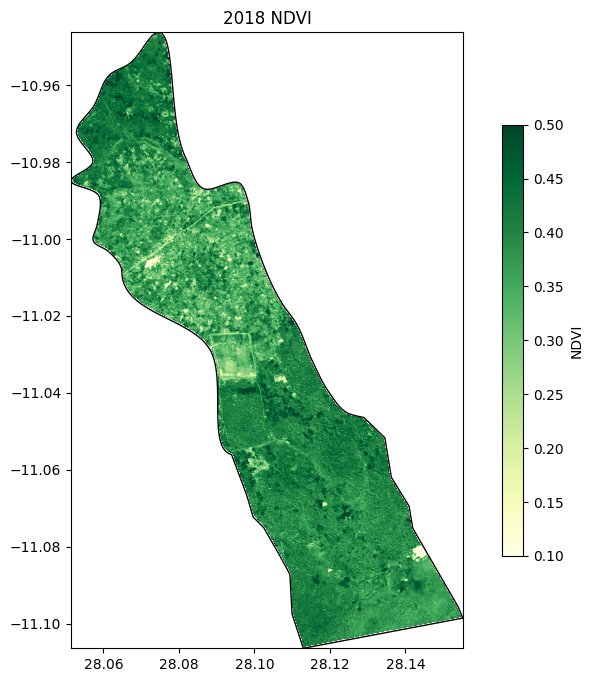

In [236]:
# Paths to files
tif_file = "framework/2018_ndvi.tif"   # Replace with your GeoTIFF path
shapefile = "roi.geojson"  # Replace with your shapefile path

# Load the GeoTIFF
with rasterio.open(tif_file) as src:
    raster = src.read(1)  # Read the first band
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    crs = src.crs  # CRS of the GeoTIFF
    
with rasterio.open(mask_layer_path) as mask_src:
    mask_data = mask_src.read(1) 

# data_masked = data * mask_data
# Mask no-data values (optional)
raster = np.ma.masked_equal(raster, src.nodata)
raster = raster * mask_data
raster = np.ma.masked_equal(raster, 0)
# Load the shapefile with Geopandas
gdf = gpd.read_file(shapefile)

# Reproject the shapefile to match the raster CRS (if necessary)
if gdf.crs != crs:
    gdf = gdf.to_crs(crs)

# Plot the data
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the GeoTIFF
cax = ax.imshow(raster, cmap="YlGn", extent=extent, vmin= 0.1, vmax = 0.5)

# Add the shapefile overlay
gdf.plot(ax=ax, facecolor="none", edgecolor="k", linewidth=1)

# Add colorbar and labels
cbar = fig.colorbar(cax, ax=ax, orientation="vertical", shrink=0.7)
cbar.set_label("NDVI")

ax.set_title("2018 NDVI")
# ax.set_xlabel("Longitude")
# ax.set_ylabel("Latitude")

# Show the plot
plt.show()


In [146]:
# Load the GeoJSON file into a GeoDataFrame
geojson_file = "roi.geojson"
gdf = gpd.read_file(geojson_file)

# Check the CRS (Coordinate Reference System)
print("Original CRS:", gdf.crs)

# If the CRS is not in meters, reproject to a CRS that uses meters (e.g., EPSG:3395 or EPSG:3857)
# You can choose an appropriate CRS based on your location or use UTM for a specific region
gdf = gdf.to_crs(epsg=3395)  # Example: WGS 84 / World Mercator (meters)

# Calculate the area for each geometry in the GeoDataFrame
gdf['area'] = gdf.geometry.area  # The area is calculated in square meters now

# Print the area values
print(gdf[['geometry', 'area']])

# # Optionally, you can save the updated GeoDataFrame with the area column to a new GeoJSON file
# gdf.to_file("output_with_area.geojson", driver="GeoJSON")


Original CRS: EPSG:4326
                                            geometry          area
0  POLYGON ((3134220.019 -1235066.228, 3134088.45...  6.550033e+07


In [254]:
# Path to your GeoTIFF
geotiff_path = "framework/World_cover_reference_layer.tif"
# geotiff_path = "framework/binary_2024_ndvi.tif"


# Open the GeoTIFF file using rasterio
with rasterio.open(geotiff_path) as src:
    # Read the raster data (first band)
    data = src.read(1)

mask_layer_path = "mask/roi_mask_v2.tif"
with rasterio.open(mask_layer_path) as mask_src:
    mask_data = mask_src.read(1) 

data_masked = data * mask_data

# Count unique values
unique_values, counts = np.unique(data_masked, return_counts=True)

masked_pixels = 1642886

# Print results
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {round(count/(np.sum(counts)-masked_pixels)*100,2)}")

Value: 0, Count: 218.49
Value: 10, Count: 42.43
Value: 20, Count: 19.59
Value: 30, Count: 34.81
Value: 40, Count: 3.04
Value: 50, Count: 0.13
Value: 60, Count: 0.0
Value: 90, Count: 0.0
